In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

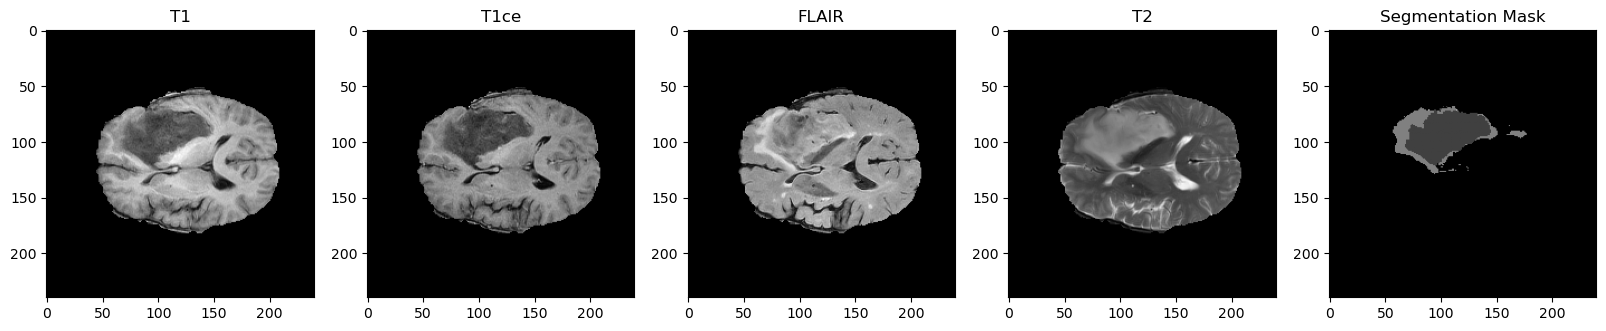

Processed image and mask saved as 'processed_image.png' and 'processed_mask.png'


In [2]:
dataset_dir = '/Users/priyanshsrivastava/Documents/Brain Brats Dataset/Dataset/BraTS2021_01512'  
t1_path = os.path.join(dataset_dir, 'BraTS2021_01512_t1.nii.gz')
t1ce_path = os.path.join(dataset_dir, 'BraTS2021_01512_t1ce.nii.gz')
flair_path = os.path.join(dataset_dir, 'BraTS2021_01512_flair.nii.gz')
t2_path = os.path.join(dataset_dir, 'BraTS2021_01512_t2.nii.gz')
seg_path = os.path.join(dataset_dir, 'BraTS2021_01512_seg.nii.gz')

t1_img = nib.load(t1_path).get_fdata()
t1ce_img = nib.load(t1ce_path).get_fdata()
flair_img = nib.load(flair_path).get_fdata()
t2_img = nib.load(t2_path).get_fdata()
seg_img = nib.load(seg_path).get_fdata()

image_shape = t1_img.shape

slice_idx = image_shape[2] // 2

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

axes[0].imshow(t1_img[:, :, slice_idx], cmap='gray')
axes[0].set_title('T1')

axes[1].imshow(t1ce_img[:, :, slice_idx], cmap='gray')
axes[1].set_title('T1ce')

axes[2].imshow(flair_img[:, :, slice_idx], cmap='gray')
axes[2].set_title('FLAIR')

axes[3].imshow(t2_img[:, :, slice_idx], cmap='gray')
axes[3].set_title('T2')

axes[4].imshow(seg_img[:, :, slice_idx], cmap='gray')
axes[4].set_title('Segmentation Mask')

plt.show()

# Here, we select T1ce as it's typically good for highlighting tumors
selected_image = t1ce_img[:, :, slice_idx]
selected_mask = seg_img[:, :, slice_idx]

# Normalize the selected image to [0, 1] range
selected_image = (selected_image - np.min(selected_image)) / (np.max(selected_image) - np.min(selected_image))

from skimage.transform import resize

target_size = (512, 512)
selected_image_resized = resize(selected_image, target_size, mode='reflect', anti_aliasing=True)
selected_mask_resized = resize(selected_mask, target_size, mode='reflect', anti_aliasing=True, preserve_range=True)

# Save the processed image and mask for training
plt.imsave('processed_image.png', selected_image_resized, cmap='gray')
plt.imsave('processed_mask.png', selected_mask_resized, cmap='gray')

print("Processed image and mask saved as 'processed_image.png' and 'processed_mask.png'")


In [3]:
#DONT RUNNNNNNNNNNNNNNNN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
image_path = '/Users/priyanshsrivastava/Documents/Brain Brats Dataset/processed_image.png'
mask_path = '/Users/priyanshsrivastava/Documents/Brain Brats Dataset/processed_mask.png'

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import numpy as np
from skimage import io

# Load the processed image and mask
image_path = '/Users/priyanshsrivastava/Documents/Brain Brats Dataset/processed_image.png'
mask_path = '/Users/priyanshsrivastava/Documents/Brain Brats Dataset/processed_mask.png'

image = io.imread(image_path, as_gray=True)
mask = io.imread(mask_path, as_gray=True)
print("IMAGE SHAPE 1:",image.shape)


train_images = np.expand_dims(image, axis=0)  # Convert to batch
train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension

input_shape = train_images.shape[1:]  # This should be (512, 512, 1)
print("IMAGE SHAPE 2:",input_shape)

# Generator model
def build_generator(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(256 * 128 * 128, activation="relu", input_shape=(100,)))
    model.add(layers.Reshape((128, 128, 256)))
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding="same", activation='tanh'))
    return model

# Discriminator model
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

def build_feature_extractor(input_shape):
    model = build_discriminator(input_shape)  # Reusing the discriminator for feature extraction
    return model

# Now use the input shape of 512x512 for both the generator and discriminator
input_shape = (512, 512, 1)

# Build the generator, discriminator, and feature extractor
generator = build_generator(input_shape)
discriminator = build_discriminator(input_shape)
feature_extractor = build_feature_extractor(input_shape)

# Define the f-AnoGAN model
class fAnoGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, feature_extractor):
        super(fAnoGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.feature_extractor = feature_extractor

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(fAnoGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, 100))

        # Generate images
        generated_images = self.generator(random_latent_vectors)

        # Train the discriminator
        with tf.GradientTape() as tape:
            real_logits = self.discriminator(real_images)
            fake_logits = self.discriminator(generated_images)
            d_loss = self.loss_fn(real_logits, fake_logits)
        d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            fake_logits = self.discriminator(generated_images)
            g_loss = -tf.reduce_mean(fake_logits)
        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

    def anomaly_score(self, real_images):
        real_features = self.feature_extractor(real_images)
        latent_space_representation = self.generator(real_images)
        generated_features = self.feature_extractor(latent_space_representation)
        anomaly_score = tf.reduce_mean(tf.abs(real_features - generated_features))
        return anomaly_score

# Build and compile the f-AnoGAN model
f_anogan = fAnoGAN(generator, discriminator, feature_extractor)
f_anogan.compile(
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=lambda real, fake: -tf.reduce_mean(real) + tf.reduce_mean(fake)
)

# Train the model
f_anogan.fit(train_images, epochs=10, batch_size=1)

# Calculate anomaly score
anomaly_score = f_anogan.anomaly_score(train_images)
print("Anomaly score: ", anomaly_score)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import numpy as np
from skimage import io



In [2]:
#this celllll

import tensorflow as tf
from tensorflow.keras import layers, models, losses
import numpy as np
from skimage import io
import os
import matplotlib.pyplot as plt

# Define latent dimension
latent_dim = 100

# Load the processed image and mask
image_path = '/Users/priyanshsrivastava/Documents/Brain Brats Dataset/61_processed_image.png'

# Load images without resizing; they should be 512x512
image = io.imread(image_path, as_gray=True)

# Ensure the image shape is correct (batch_size, height, width, channels)
train_images = np.expand_dims(image, axis=0)  # Convert to batch
train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension

# Define input shape
input_shape = (512, 512, 1)

# Build the Generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(256 * 128 * 128, activation="relu", input_shape=(latent_dim,)))
    model.add(layers.Reshape((128, 128, 256)))
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding="same", activation='tanh'))
    return model

# Build the Discriminator model
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# WGAN model
class WGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, real_images):
        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # Generate random noise vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine real and fake images
        combined_images = tf.concat([real_images, generated_images], axis=0)

        # Label real images as 1 and fake images as 0
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add random noise to labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.d_loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Generate random noise vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Label generated images as 1 (the trick here)
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(generated_images)
            g_loss = self.g_loss_fn(generated_images, real_images)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, generator, latent_dim, save_interval, output_dir):
        self.generator = generator
        self.latent_dim = latent_dim
        self.save_interval = save_interval
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_interval == 0:
            # Save model weights
            self.model.generator.save_weights(os.path.join(self.output_dir, f'generator_weights_epoch_{epoch + 1}.h5'))
            self.model.discriminator.save_weights(os.path.join(self.output_dir, f'discriminator_weights_epoch_{epoch + 1}.h5'))

            # Generate and save output image
            random_latent_vectors = tf.random.normal(shape=(1, self.latent_dim))
            generated_image = self.generator(random_latent_vectors)[0, :, :, 0]
            plt.figure(figsize=(6, 6))
            plt.imshow(generated_image, cmap='gray')
            plt.axis('off')
            plt.savefig(os.path.join(self.output_dir, f'generated_image_epoch_{epoch + 1}.png'))
            plt.close()

# Define output directory and save interval
output_dir = '/Users/priyanshsrivastava/Documents/Brain Brats Dataset/wgan_output'
save_interval = 50

# Create custom callback instance


# Instantiate models
generator = build_generator(latent_dim)
discriminator = build_discriminator(input_shape)

custom_callback = CustomCallback(generator, latent_dim, save_interval, output_dir)
# Instantiate WGAN model
wgan = WGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile the model
wgan.compile(
    d_optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005),
    g_optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    d_loss_fn=losses.BinaryCrossentropy(from_logits=True),
    g_loss_fn=ssim_loss  # Use SSIM loss for the generator
)

# Train the model with the custom callback
wgan.fit(train_images, epochs=500, batch_size=1, callbacks=[custom_callback])


Epoch 1/500
1/1 [==============================] - 14s 14s/step - d_loss: 0.6919 - g_loss: 0.3640
Epoch 2/500
1/1 [==============================] - 21s 21s/step - d_loss: 8.7363 - g_loss: 0.3789
Epoch 3/500
1/1 [==============================] - 32s 32s/step - d_loss: 956.5838 - g_loss: 0.3645
Epoch 4/500
1/1 [==============================] - 29s 29s/step - d_loss: 21192.9785 - g_loss: 0.3636
Epoch 5/500
1/1 [==============================] - 27s 27s/step - d_loss: 2790.7903 - g_loss: 0.3634
Epoch 6/500
1/1 [==============================] - 29s 29s/step - d_loss: 2288.1943 - g_loss: 0.3632
Epoch 7/500
1/1 [==============================] - 30s 30s/step - d_loss: 2639.2505 - g_loss: 0.3631
Epoch 8/500
1/1 [==============================] - 29s 29s/step - d_loss: 165.4556 - g_loss: 0.3633
Epoch 9/500
1/1 [==============================] - 31s 31s/step - d_loss: -3.3639 - g_loss: 0.3632
Epoch 10/500
1/1 [==============================] - 29s 29s/step - d_loss: -2.0655 - g_loss: 0.3632


1/1 [==============================] - 19s 19s/step - d_loss: -45855112.0000 - g_loss: 0.3631
Epoch 81/500
1/1 [==============================] - 18s 18s/step - d_loss: -62852076.0000 - g_loss: 0.3633
Epoch 82/500
1/1 [==============================] - 18s 18s/step - d_loss: -61673144.0000 - g_loss: 0.3631
Epoch 83/500
1/1 [==============================] - 915s 915s/step - d_loss: -215473536.0000 - g_loss: 0.3629
Epoch 84/500
1/1 [==============================] - 18s 18s/step - d_loss: -181661632.0000 - g_loss: 0.3628
Epoch 85/500
1/1 [==============================] - 25s 25s/step - d_loss: -121875808.0000 - g_loss: 0.3628
Epoch 86/500
1/1 [==============================] - 20s 20s/step - d_loss: -273106176.0000 - g_loss: 0.3628
Epoch 87/500
1/1 [==============================] - 16s 16s/step - d_loss: -163811328.0000 - g_loss: 0.3628
Epoch 88/500
1/1 [==============================] - 14s 14s/step - d_loss: -291023296.0000 - g_loss: 0.3628
Epoch 89/500
1/1 [========================

1/1 [==============================] - 7s 7s/step - d_loss: -1522987520.0000 - g_loss: 0.3627
Epoch 156/500
1/1 [==============================] - 7s 7s/step - d_loss: -2539086848.0000 - g_loss: 0.3627
Epoch 157/500
1/1 [==============================] - 21s 21s/step - d_loss: -446909536.0000 - g_loss: 0.3627
Epoch 158/500
1/1 [==============================] - 28s 28s/step - d_loss: -2256300032.0000 - g_loss: 0.3627
Epoch 159/500
1/1 [==============================] - 24s 24s/step - d_loss: -3469477632.0000 - g_loss: 0.3627
Epoch 160/500
1/1 [==============================] - 23s 23s/step - d_loss: -483399328.0000 - g_loss: 0.3627
Epoch 161/500
1/1 [==============================] - 23s 23s/step - d_loss: -1910005888.0000 - g_loss: 0.3627
Epoch 162/500
1/1 [==============================] - 23s 23s/step - d_loss: -2922538240.0000 - g_loss: 0.3627
Epoch 163/500
1/1 [==============================] - 45s 45s/step - d_loss: -682563328.0000 - g_loss: 0.3627
Epoch 164/500
1/1 [============

1/1 [==============================] - 10s 10s/step - d_loss: -20270872576.0000 - g_loss: 0.3627
Epoch 230/500
1/1 [==============================] - 9s 9s/step - d_loss: -12912048128.0000 - g_loss: 0.3627
Epoch 231/500
1/1 [==============================] - 9s 9s/step - d_loss: -7673322496.0000 - g_loss: 0.3627
Epoch 232/500
1/1 [==============================] - 10s 10s/step - d_loss: -17858918400.0000 - g_loss: 0.3627
Epoch 233/500
1/1 [==============================] - 9s 9s/step - d_loss: -1016595968.0000 - g_loss: 0.3627
Epoch 234/500
1/1 [==============================] - 8s 8s/step - d_loss: -12049596416.0000 - g_loss: 0.3627
Epoch 235/500
1/1 [==============================] - 7s 7s/step - d_loss: -1964032384.0000 - g_loss: 0.3627
Epoch 236/500
1/1 [==============================] - 10s 10s/step - d_loss: -12991480832.0000 - g_loss: 0.3627
Epoch 237/500
1/1 [==============================] - 9s 9s/step - d_loss: -10882313216.0000 - g_loss: 0.3627
Epoch 238/500
1/1 [===========

1/1 [==============================] - 11s 11s/step - d_loss: -65523785728.0000 - g_loss: 0.3627
Epoch 305/500
1/1 [==============================] - 12s 12s/step - d_loss: -74847707136.0000 - g_loss: 0.3627
Epoch 306/500
1/1 [==============================] - 10s 10s/step - d_loss: -26022899712.0000 - g_loss: 0.3627
Epoch 307/500
1/1 [==============================] - 10s 10s/step - d_loss: -77240442880.0000 - g_loss: 0.3627
Epoch 308/500
1/1 [==============================] - 9s 9s/step - d_loss: -1744046976.0000 - g_loss: 0.3627
Epoch 309/500
1/1 [==============================] - 11s 11s/step - d_loss: -789704000.0000 - g_loss: 0.3627
Epoch 310/500
1/1 [==============================] - 11s 11s/step - d_loss: -56660312064.0000 - g_loss: 0.3627
Epoch 311/500
1/1 [==============================] - 10s 10s/step - d_loss: -78639923200.0000 - g_loss: 0.3627
Epoch 312/500
1/1 [==============================] - 893s 893s/step - d_loss: -83415433216.0000 - g_loss: 0.3627
Epoch 313/500
1/1 

1/1 [==============================] - 9s 9s/step - d_loss: -173513687040.0000 - g_loss: 0.3627
Epoch 379/500
1/1 [==============================] - 8s 8s/step - d_loss: -103439327232.0000 - g_loss: 0.3627
Epoch 380/500
1/1 [==============================] - 6s 6s/step - d_loss: -24672043008.0000 - g_loss: 0.3627
Epoch 381/500
1/1 [==============================] - 9s 9s/step - d_loss: -28078491648.0000 - g_loss: 0.3627
Epoch 382/500
1/1 [==============================] - 7s 7s/step - d_loss: -144919150592.0000 - g_loss: 0.3627
Epoch 383/500
1/1 [==============================] - 936s 936s/step - d_loss: -36035989504.0000 - g_loss: 0.3627
Epoch 384/500
1/1 [==============================] - 13s 13s/step - d_loss: -59905560576.0000 - g_loss: 0.3627
Epoch 385/500
1/1 [==============================] - 11s 11s/step - d_loss: -120649547776.0000 - g_loss: 0.3627
Epoch 386/500
1/1 [==============================] - 14s 14s/step - d_loss: -15729397760.0000 - g_loss: 0.3627
Epoch 387/500
1/1 [

1/1 [==============================] - 8s 8s/step - d_loss: -222061969408.0000 - g_loss: 0.3627
Epoch 453/500
1/1 [==============================] - 7s 7s/step - d_loss: -248528699392.0000 - g_loss: 0.3627
Epoch 454/500
1/1 [==============================] - 8s 8s/step - d_loss: -356382670848.0000 - g_loss: 0.3627
Epoch 455/500
1/1 [==============================] - 5s 5s/step - d_loss: -144852533248.0000 - g_loss: 0.3627
Epoch 456/500
1/1 [==============================] - 6s 6s/step - d_loss: -352317112320.0000 - g_loss: 0.3627
Epoch 457/500
1/1 [==============================] - 7s 7s/step - d_loss: -312484233216.0000 - g_loss: 0.3627
Epoch 458/500
1/1 [==============================] - 9s 9s/step - d_loss: -92475670528.0000 - g_loss: 0.3627
Epoch 459/500
1/1 [==============================] - 7s 7s/step - d_loss: -144703029248.0000 - g_loss: 0.3627
Epoch 460/500
1/1 [==============================] - 7s 7s/step - d_loss: -54398156800.0000 - g_loss: 0.3627
Epoch 461/500
1/1 [=======

In [2]:
wgan

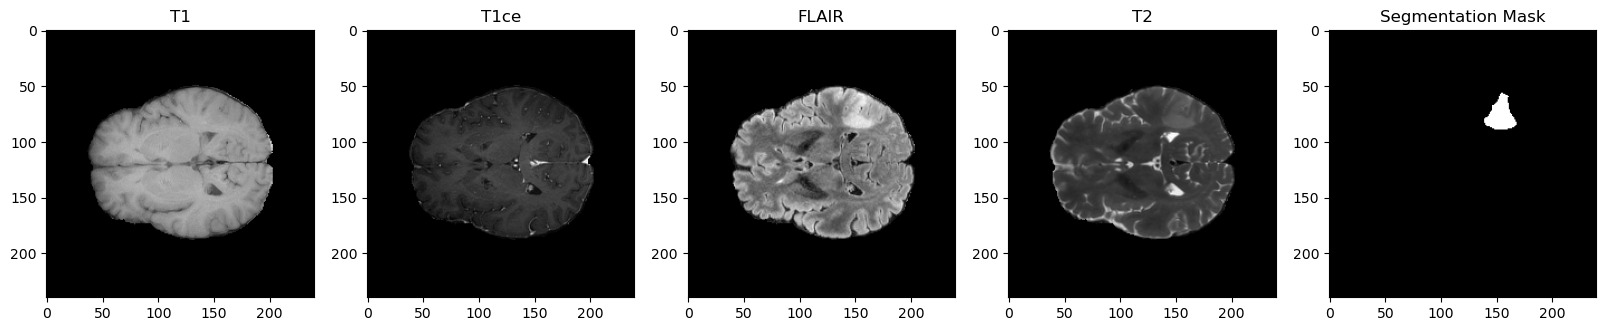

Processed image and mask saved as 'processed_image.png' and 'processed_mask.png'


In [9]:
dataset_dir = '/Users/priyanshsrivastava/Documents/Brain Brats Dataset/BraTS2021_00008'  # Replace with the correct path
t1_path = os.path.join(dataset_dir, 'BraTS2021_00008_t1.nii.gz')
t1ce_path = os.path.join(dataset_dir, 'BraTS2021_00008_t1ce.nii.gz')
flair_path = os.path.join(dataset_dir, 'BraTS2021_00008_flair.nii.gz')
t2_path = os.path.join(dataset_dir, 'BraTS2021_00008_t2.nii.gz')
seg_path = os.path.join(dataset_dir, 'BraTS2021_00008_seg.nii.gz')

t1_img = nib.load(t1_path).get_fdata()
t1ce_img = nib.load(t1ce_path).get_fdata()
flair_img = nib.load(flair_path).get_fdata()
t2_img = nib.load(t2_path).get_fdata()
seg_img = nib.load(seg_path).get_fdata()

image_shape = t1_img.shape

slice_idx = image_shape[2] // 2

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

axes[0].imshow(t1_img[:, :, slice_idx], cmap='gray')
axes[0].set_title('T1')

axes[1].imshow(t1ce_img[:, :, slice_idx], cmap='gray')
axes[1].set_title('T1ce')

axes[2].imshow(flair_img[:, :, slice_idx], cmap='gray')
axes[2].set_title('FLAIR')

axes[3].imshow(t2_img[:, :, slice_idx], cmap='gray')
axes[3].set_title('T2')

axes[4].imshow(seg_img[:, :, slice_idx], cmap='gray')
axes[4].set_title('Segmentation Mask')

plt.show()

# Here, we select T1ce as it's typically good for highlighting tumors
selected_image = t1ce_img[:, :, slice_idx]
selected_mask = seg_img[:, :, slice_idx]

# Normalize the selected image to [0, 1] range
selected_image = (selected_image - np.min(selected_image)) / (np.max(selected_image) - np.min(selected_image))

from skimage.transform import resize

target_size = (512, 512)
selected_image_resized = resize(selected_image, target_size, mode='reflect', anti_aliasing=True)
selected_mask_resized = resize(selected_mask, target_size, mode='reflect', anti_aliasing=True, preserve_range=True)

# Save the processed image and mask for training
plt.imsave('test_processed_image.png', selected_image_resized, cmap='gray')
plt.imsave('test_processed_mask.png', selected_mask_resized, cmap='gray')

print("Processed image and mask saved as 'processed_image.png' and 'processed_mask.png'")


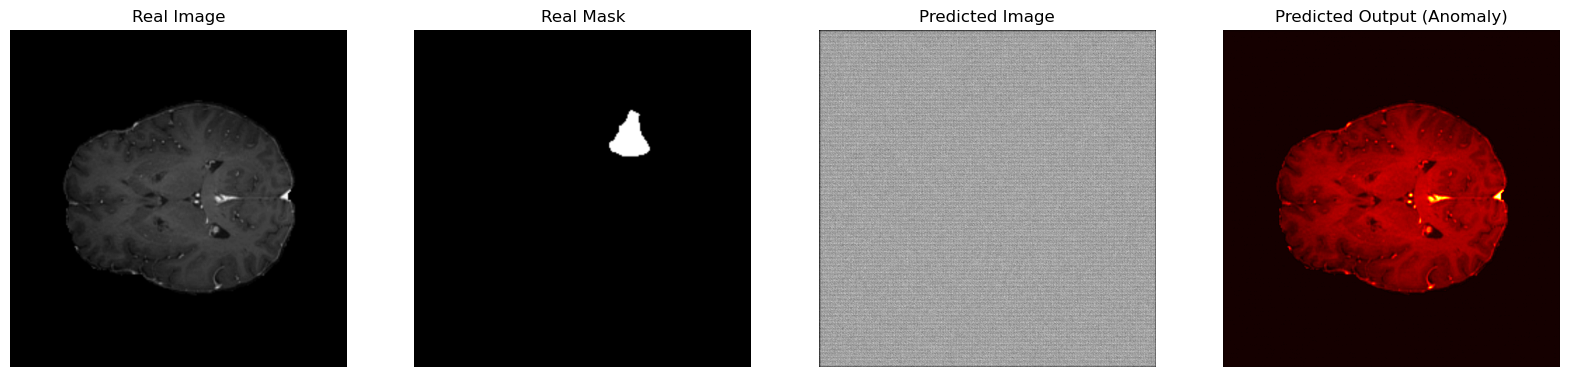

In [7]:
import matplotlib.pyplot as plt

# Load the test image and mask
test_image_path = 'test_processed_image.png'
test_mask_path = 'test_processed_mask.png'

# Load the test image
test_image = io.imread(test_image_path, as_gray=True)
test_mask = io.imread(test_mask_path, as_gray=True)

test_image = np.expand_dims(test_image, axis=0)  # Convert to batch
test_image = np.expand_dims(test_image, axis=-1)  # Add channel dimension

# Generate the predicted image using the trained generator
predicted_image = generator(random_latent_vector)

# Calculate the anomaly by subtracting the predicted image from the real image
predicted_output = tf.abs(test_image - predicted_image)

# Reshape images for display without squeezing
real_image = test_image[0, :, :, 0]  # Take the first image and remove batch and channel dimensions
real_mask = test_mask  # Mask is already 2D
predicted_image = predicted_image[0, :, :, 0]  # Take the first image and remove batch and channel dimensions
predicted_output = predicted_output[0, :, :, 0]  # Take the first image and remove batch and channel dimensions

# Plot real image, real mask, predicted image, and predicted output
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Real Image
axs[0].imshow(real_image, cmap='gray')
axs[0].set_title('Real Image')
axs[0].axis('off')

# Real Mask
axs[1].imshow(real_mask, cmap='gray')
axs[1].set_title('Real Mask')
axs[1].axis('off')

# Predicted Image
axs[2].imshow(predicted_image, cmap='gray')
axs[2].set_title('Predicted Image')
axs[2].axis('off')

# Predicted Output (Anomaly)
axs[3].imshow(predicted_output, cmap='hot')
axs[3].set_title('Predicted Output (Anomaly)')
axs[3].axis('off')

plt.show()
